In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'adult-income-census:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5129250%2F8577372%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240601%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240601T182455Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2bf0431d28b468a6e39efe3ee36d3fba8ca29d5dc04747343f5ccaa58dc9c39136370b65513efcb6e8d829415038513a23f37b193d0c55ad5482bcfac26234a4f73d57a447f07159db401c79da8cb109cd604f04f8bfc4525e45528e48a3928598495f6d0f4f1adcdb6e004c24fa1d7aa5ed4bd7f36c06cd16a045cc9d72d02559846a36f80fff92b4c0658d7f597748a4f9f543bc9eef4428fffa2d56e956d8fa9ca8ccb5d5c517e4ee4b7c4452e4ef162108b1af2920da38ee26e26c872d29d0fb2676fecff561d425eedc50841084771f338f475c48c92d5f805fb024e55109ce788d9991260d1b03906fa834e69bc56d4695d277af9713d6df32469a237d'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')



[==================================================] 460936 bytes downloaded

Downloaded and uncompressed: adult-income-census

Data source import complete.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = (12,8)
from sklearn.preprocessing import MinMaxScaler , StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score,f1_score, ConfusionMatrixDisplay



In [3]:
# Loading the dataset
data = pd.read_csv('/kaggle/input/adult-income-census/adult.csv')
data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [4]:
data[data == '?'] = np.nan
data.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 32561 entries, 0 to 32560

Data columns (total 15 columns):

 #   Column          Non-Null Count  Dtype 

---  ------          --------------  ----- 

 0   age             32561 non-null  int64 

 1   workclass       30725 non-null  object

 2   fnlwgt          32561 non-null  int64 

 3   education       32561 non-null  object

 4   education.num   32561 non-null  int64 

 5   marital.status  32561 non-null  object

 6   occupation      30718 non-null  object

 7   relationship    32561 non-null  object

 8   race            32561 non-null  object

 9   sex             32561 non-null  object

 10  capital.gain    32561 non-null  int64 

 11  capital.loss    32561 non-null  int64 

 12  hours.per.week  32561 non-null  int64 

 13  native.country  31978 non-null  object

 14  income          32561 non-null  object

dtypes: int64(6), object(9)

memory usage: 3.7+ MB


<Axes: >

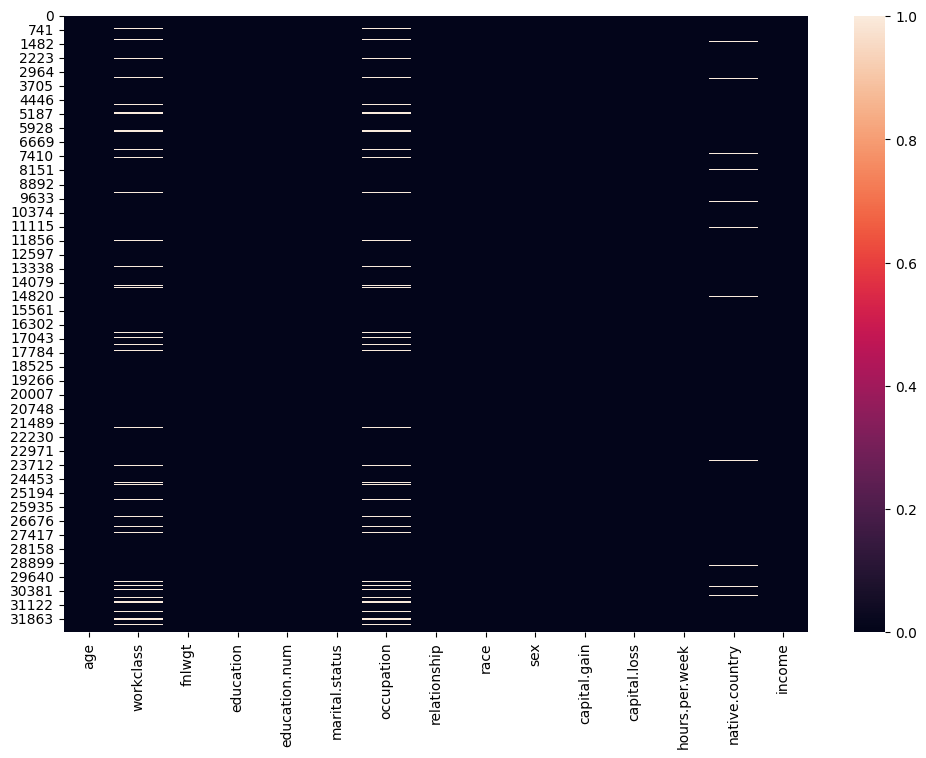

In [5]:
plt.figure(figsize=(12,8))
sns.heatmap(data.isnull()) #white lines are null values

In [6]:
for col in ['workclass', 'occupation', 'native.country']:
    data[col].fillna(data[col].mode()[0], inplace=True)

In [7]:
data.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

<Axes: >

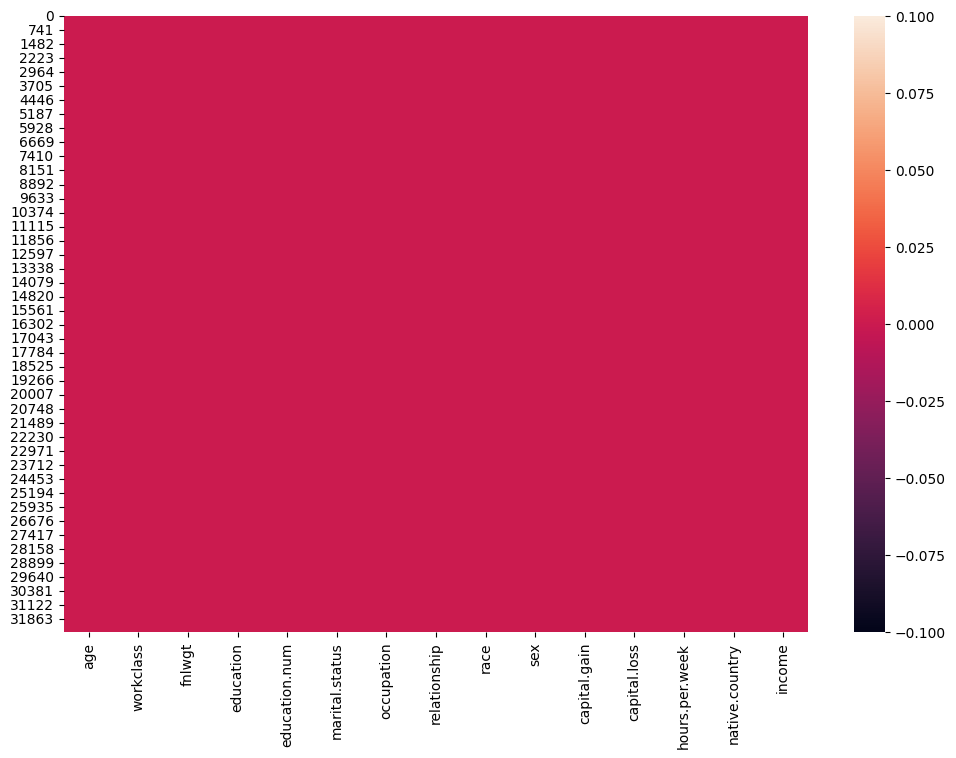

In [8]:
plt.figure(figsize=(12,8))
sns.heatmap(data.isnull())

In [9]:
data[data.duplicated(keep=False)]

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
6227,90,Private,52386,Some-college,10,Never-married,Other-service,Not-in-family,Asian-Pac-Islander,Male,0,0,35,United-States,<=50K
7615,19,Private,251579,Some-college,10,Never-married,Other-service,Own-child,White,Male,0,0,14,United-States,<=50K
7978,25,Private,308144,Bachelors,13,Never-married,Craft-repair,Not-in-family,White,Male,0,0,40,Mexico,<=50K
8356,21,Private,250051,Some-college,10,Never-married,Prof-specialty,Own-child,White,Female,0,0,10,United-States,<=50K
8453,25,Private,308144,Bachelors,13,Never-married,Craft-repair,Not-in-family,White,Male,0,0,40,Mexico,<=50K
8500,38,Private,207202,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,48,United-States,>50K
8645,90,Private,52386,Some-college,10,Never-married,Other-service,Not-in-family,Asian-Pac-Islander,Male,0,0,35,United-States,<=50K
9067,27,Private,255582,HS-grad,9,Never-married,Machine-op-inspct,Not-in-family,White,Female,0,0,40,United-States,<=50K
9269,20,Private,107658,Some-college,10,Never-married,Tech-support,Not-in-family,White,Female,0,0,10,United-States,<=50K
9305,25,Private,195994,1st-4th,2,Never-married,Priv-house-serv,Not-in-family,White,Female,0,0,40,Guatemala,<=50K


In [10]:
data.duplicated().sum()

24

In [11]:
data.drop_duplicates(inplace=True)

In [12]:
data.shape

(32537, 15)

In [13]:
data.nunique().sort_values()

sex                   2
income                2
race                  5
relationship          6
marital.status        7
workclass             8
occupation           14
education            16
education.num        16
native.country       41
age                  73
capital.loss         92
hours.per.week       94
capital.gain        119
fnlwgt            21648
dtype: int64

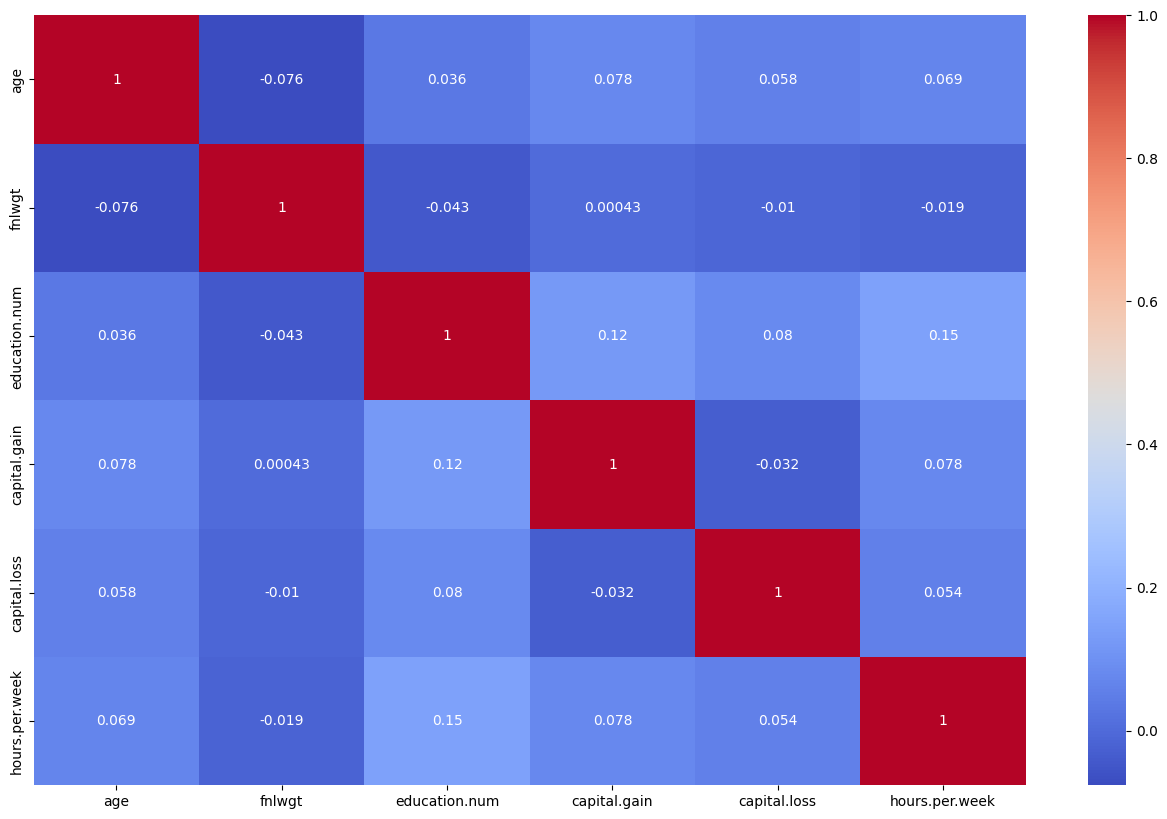

In [14]:
numeric_columns = data.select_dtypes(include=['number'])
plt.figure(figsize = (16, 10))
sns.heatmap(numeric_columns.corr(), annot = True, cmap="coolwarm")
plt.show()


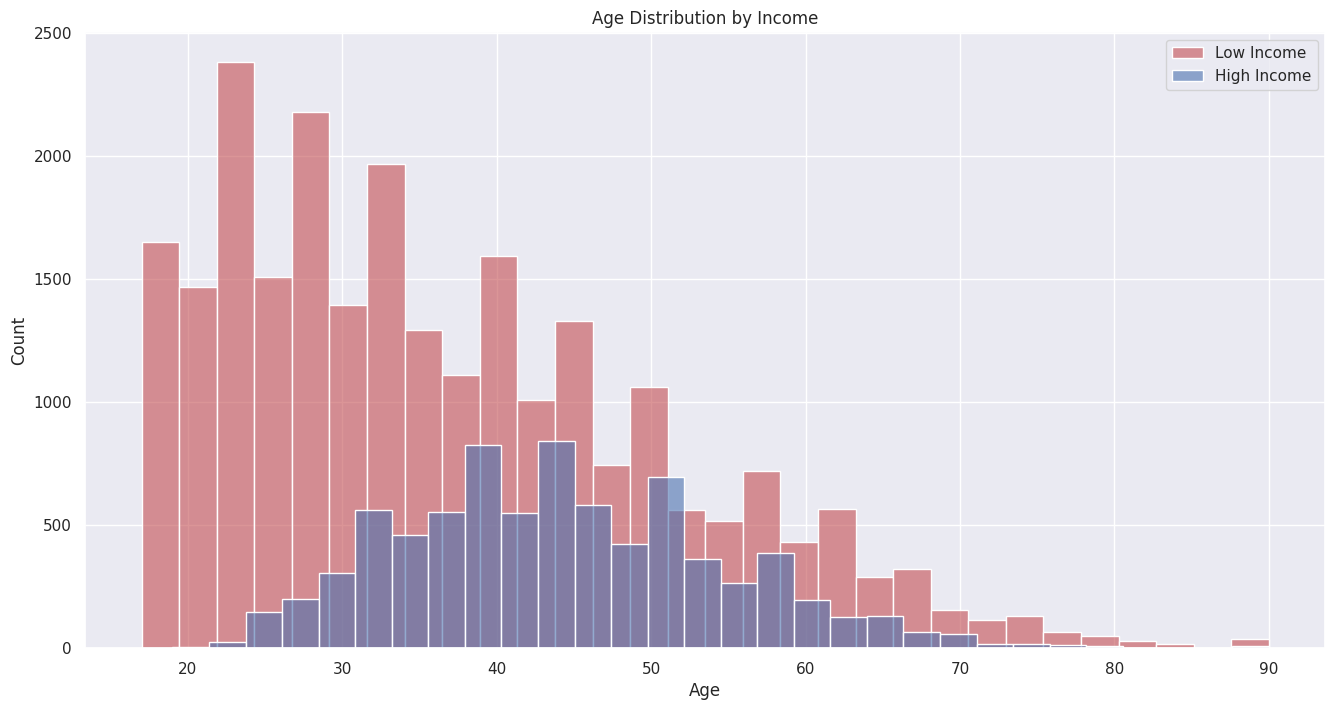

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 8))

sns.set_theme(style="darkgrid")
sns.set_palette("magma")

# Plot histogram for Low Income
sns.histplot(data=data[data['income'] == '<=50K'], x='age', bins=30, kde=False, color="r", label="Low Income", alpha=0.6)

# Plot histogram for High Income
sns.histplot(data=data[data['income'] == '>50K'], x='age', bins=30, kde=False, color="b", label="High Income", alpha=0.6)

plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution by Income')

plt.legend()

plt.show()


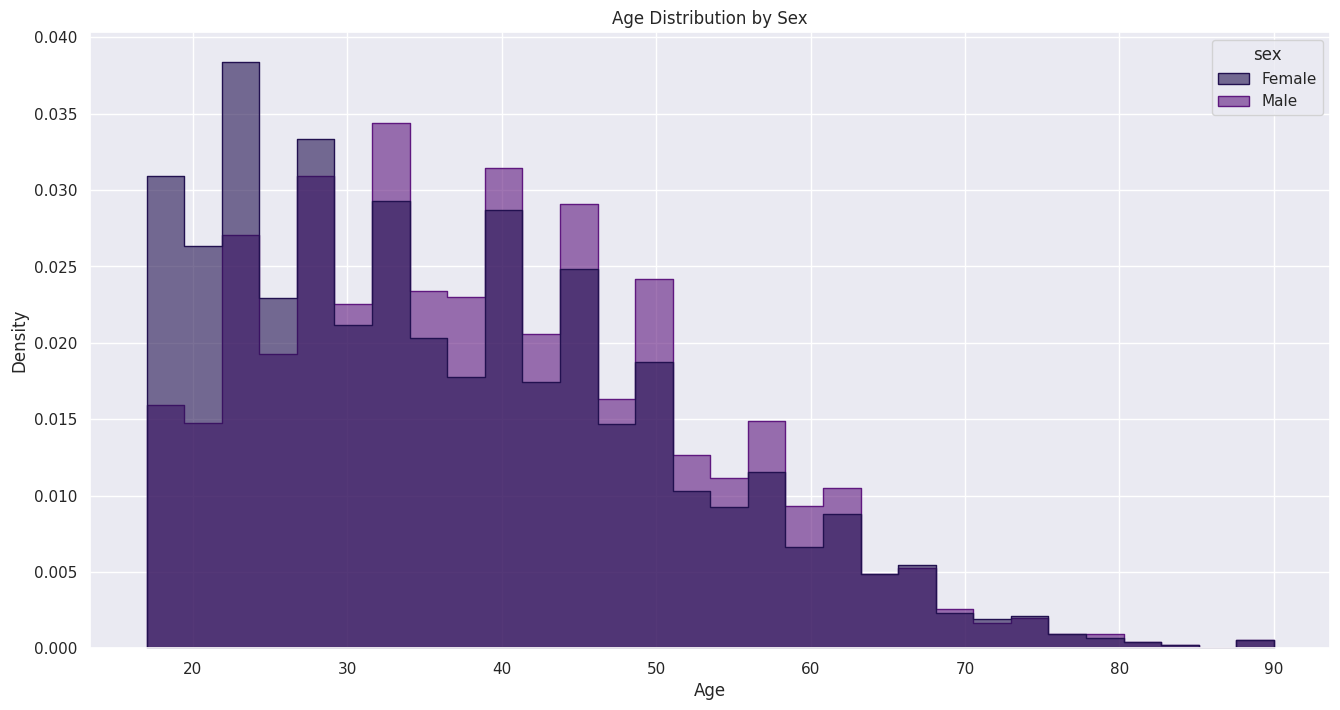

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 8))

sns.set_theme(style="darkgrid")
sns.set_palette("magma")

# Plot histogram for Age distribution by Sex
sns.histplot(data=data, x='age', hue='sex', bins=30, kde=False, element="step", stat="density", common_norm=False, alpha=0.6)

plt.xlabel('Age')
plt.ylabel('Density')
plt.title('Age Distribution by Sex')

plt.show()


In [17]:
data.groupby('workclass').size()

workclass
Federal-gov           960
Local-gov            2093
Never-worked            7
Private             24509
Self-emp-inc         1116
Self-emp-not-inc     2540
State-gov            1298
Without-pay            14
dtype: int64

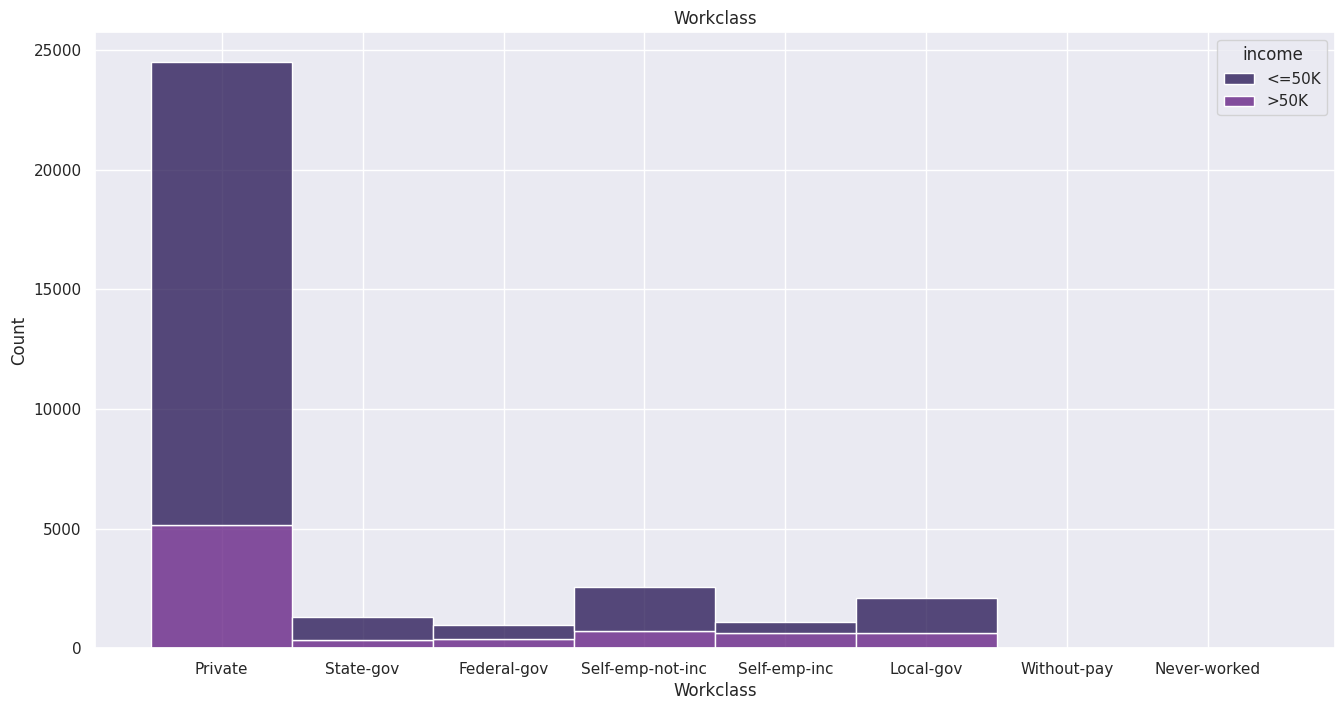

In [18]:
plt.figure(figsize=(16, 8))

sns.histplot(data=data, x='workclass', hue='income', multiple='stack')

plt.xlabel('Workclass')
plt.title('Workclass')

plt.show()

In [19]:
data.groupby('education').size()

education
10th              933
11th             1175
12th              433
1st-4th           166
5th-6th           332
7th-8th           645
9th               514
Assoc-acdm       1067
Assoc-voc        1382
Bachelors        5353
Doctorate         413
HS-grad         10494
Masters          1722
Preschool          50
Prof-school       576
Some-college     7282
dtype: int64

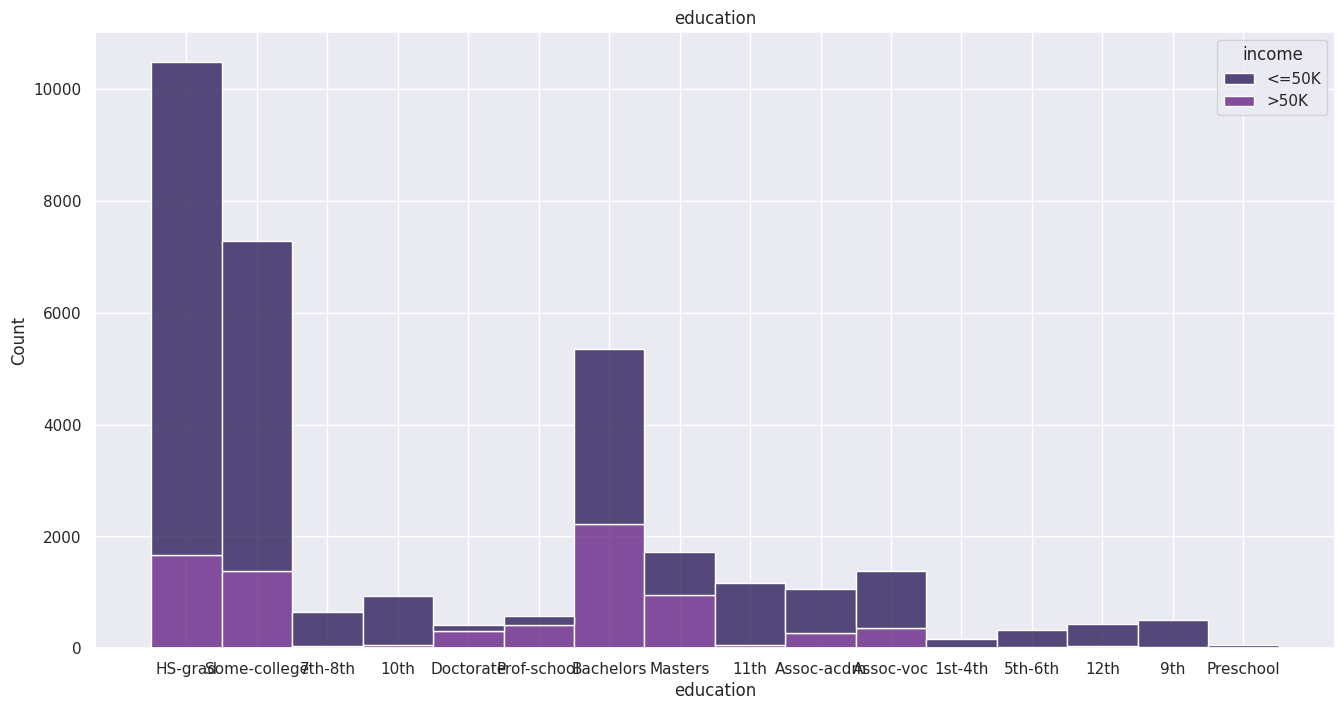

In [20]:
plt.figure(figsize=(16, 8))

sns.histplot(data=data, x='education', hue='income', multiple='stack')

plt.xlabel('education')
plt.title('education')

plt.show()

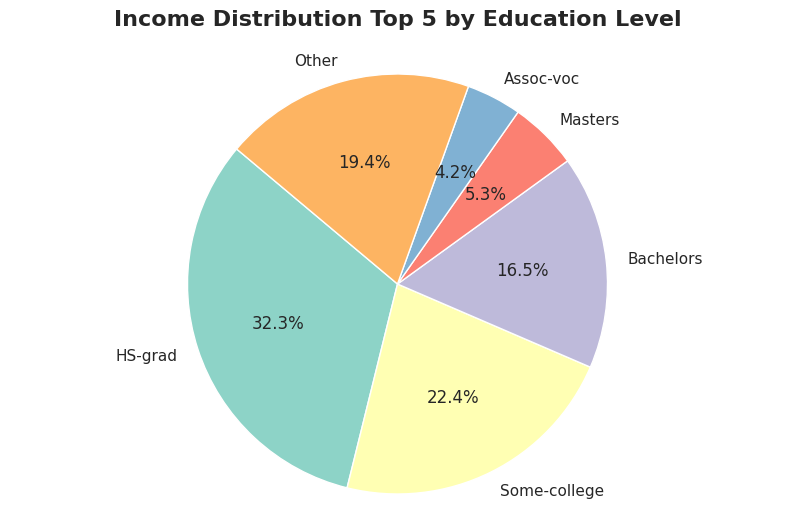

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming your DataFrame is named data
education_counts = data['education'].value_counts()

top_5_education_counts = education_counts[:5]
other_count = education_counts[5:].sum()

# Create a list of colors
colors = plt.cm.Set3(range(6))

# Labels and sizes for the pie chart
labels = list(top_5_education_counts.index)
labels.append('Other')

sizes = list(top_5_education_counts.values)
sizes.append(other_count)

# Plotting the pie chart
plt.figure(figsize=(10, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
plt.title('Income Distribution Top 5 by Education Level', fontsize=16, fontweight='bold', pad=20)
plt.axis('equal')

# Show the plot
plt.show()


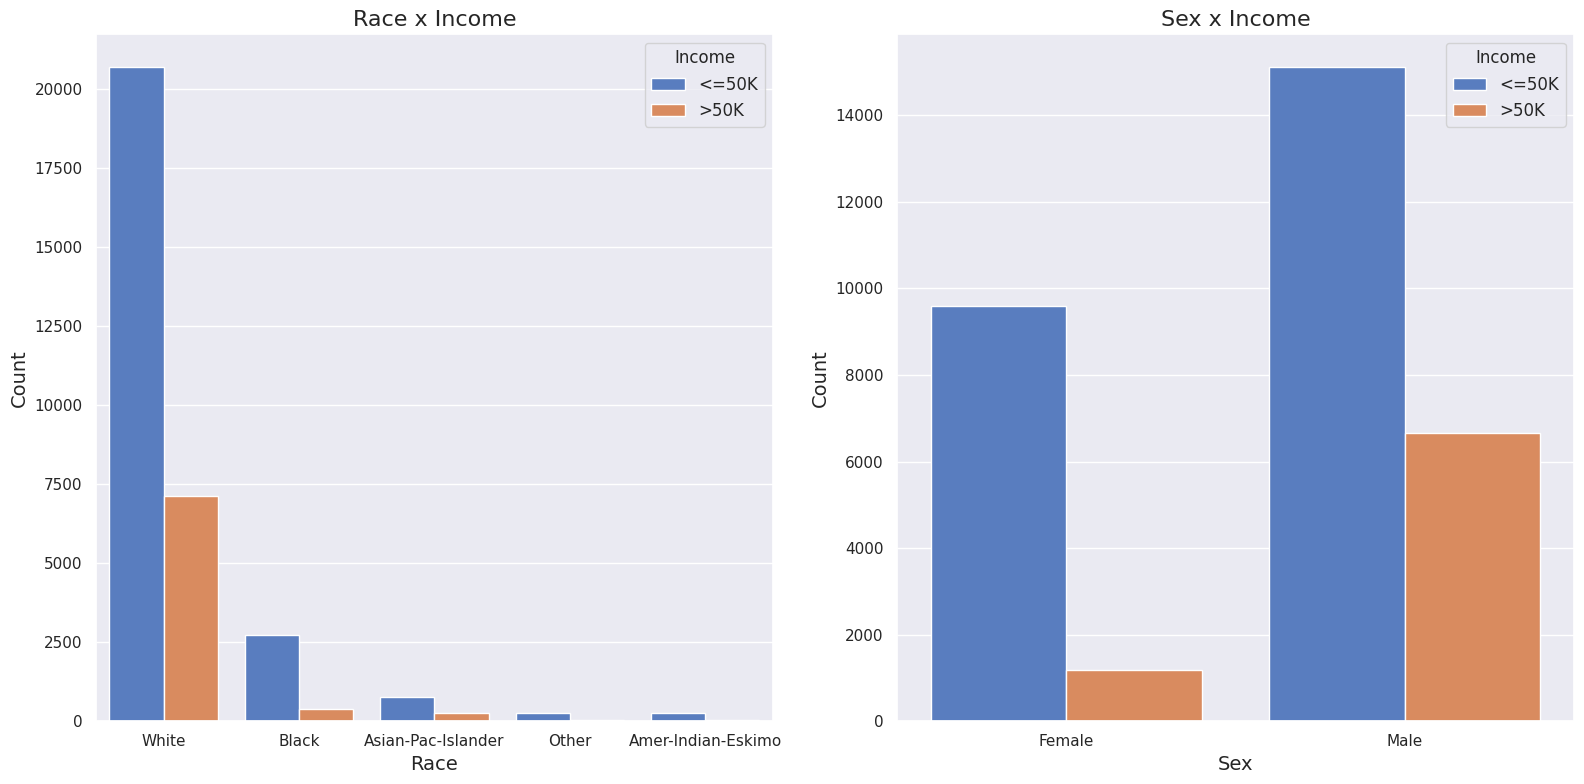

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

sns.countplot(data=data, x='race', hue='income', palette='muted', ax=axes[0])
axes[0].set_title('Race x Income', fontsize=16)
axes[0].set_xlabel('Race', fontsize=14)
axes[0].set_ylabel('Count', fontsize=14)
axes[0].legend(title='Income', fontsize=12)

sns.countplot(data=data, x='sex', hue='income', palette='muted', ax=axes[1])
axes[1].set_title('Sex x Income', fontsize=16)
axes[1].set_xlabel('Sex', fontsize=14)
axes[1].set_ylabel('Count', fontsize=14)
axes[1].legend(title='Income', fontsize=12)


plt.tight_layout()

plt.show()

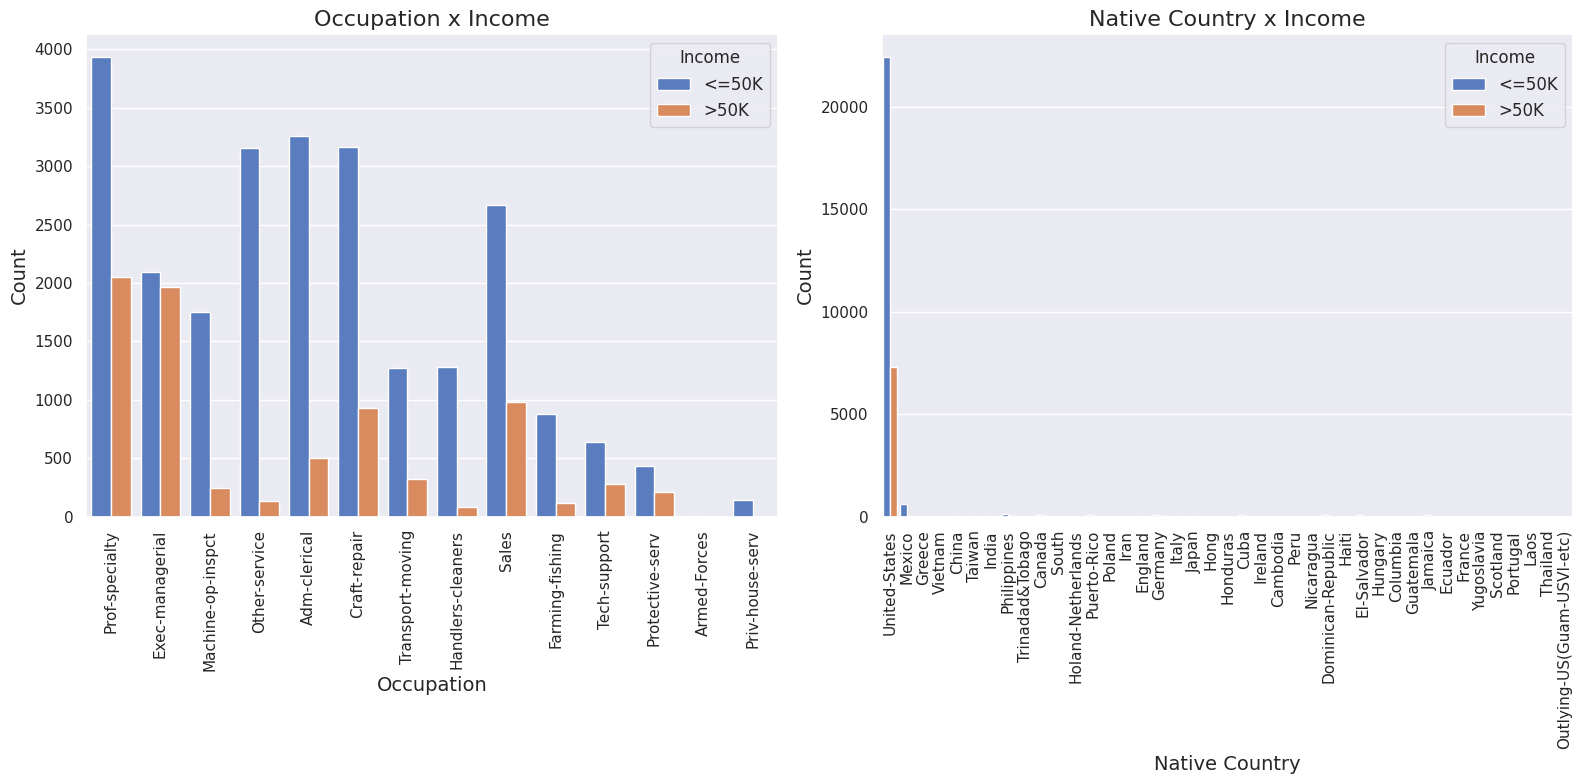

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

#
sns.countplot(data=data, x='occupation', hue='income', palette='muted', ax=axes[0])
axes[0].set_title('Occupation x Income', fontsize=16)
axes[0].set_xlabel('Occupation', fontsize=14)
axes[0].set_ylabel('Count', fontsize=14)
axes[0].legend(title='Income', fontsize=12)
axes[0].tick_params(axis='x', rotation=90)


sns.countplot(data=data, x='native.country', hue='income', palette='muted', ax=axes[1])
axes[1].set_title('Native Country x Income', fontsize=16)
axes[1].set_xlabel('Native Country', fontsize=14)
axes[1].set_ylabel('Count', fontsize=14)
axes[1].legend(title='Income', fontsize=12)
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


In [25]:



print(f"Number of columns before deleting: {data.shape[1]}")

del_cols = ['relationship','education.num']
data.drop(labels = del_cols,axis = 1,inplace = True)
print(f"Number of columns after deleting: {data.shape[1]}")

Number of columns before deleting: 15

Number of columns after deleting: 13


In [26]:
hrs_per_week = data[data['hours.per.week'] == 99]
print("Number of people working for 99 hours per week:", hrs_per_week.shape[0])

Number of people working for 99 hours per week: 85


In [27]:
print("Number of observation before removing:",data.shape)
index_age = data[data['age'] == 90].index
data.drop(labels = index_age,axis = 0,inplace =True)
print("Number of observation after removing:",data.shape)

Number of observation before removing: (32537, 13)

Number of observation after removing: (32495, 13)


In [28]:
print("Number of observation before removing:",data.shape)
index_gain = data[data['capital.gain'] == 99999].index
data.drop(labels = index_gain,axis = 0,inplace =True)
print("Number of observation after removing:",data.shape)

Number of observation before removing: (32495, 13)

Number of observation after removing: (32336, 13)


In [29]:
num_col_new = ['age','capital.gain', 'capital.loss',
       'hours.per.week','fnlwgt']
cat_col_new = ['workclass', 'education', 'marital.status', 'occupation',
               'race', 'sex', 'native.country', 'income']

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = MinMaxScaler()
pd.DataFrame(scaler.fit_transform(data[num_col_new]),columns = num_col_new).head(3)

,age,capital.gain,capital.loss,hours.per.week,fnlwgt
0,0.915493,0.0,1.000000,0.173469,0.081896
1,0.690141,0.0,1.000000,0.397959,0.118021
2,0.521127,0.0,0.895317,0.397959,0.086982


In [32]:
class DataFrameSelector(TransformerMixin):
    def __init__(self,attribute_names):
        self.attribute_names = attribute_names

    def fit(self,X,y = None):
        return self

    def transform(self,X):
        return X[self.attribute_names]


class num_trans(TransformerMixin):
    def __init__(self):
        pass

    def fit(self,X,y=None):
        return self

    def transform(self,X):
        df = pd.DataFrame(X)
        df.columns = num_col_new
        return df



pipeline = Pipeline([('selector',DataFrameSelector(num_col_new)),
                     ('scaler',MinMaxScaler()),
                    ('transform',num_trans())])

In [33]:
num_df = pipeline.fit_transform(data)
num_df.shape

(32336, 5)

In [34]:
cols = ['workclass_Govt_employess','education_Some-college',
        'marital.status_Never-married','occupation_Other-service',
        'race_Black','sex_Male','income_>50K']

In [35]:
class dummies(TransformerMixin):
    def __init__(self,cols):
        self.cols = cols

    def fit(self,X,y = None):
        return self

    def transform(self,X):
        df = pd.get_dummies(X)
        df_new = df[df.columns.difference(cols)]
#difference returns the original columns, with the columns passed as argument removed.
        return df_new

pipeline_cat=Pipeline([('selector',DataFrameSelector(cat_col_new)),
                      ('dummies',dummies(cols))])
cat_df = pipeline_cat.fit_transform(data)
cat_df.shape

(32336, 89)

In [36]:
cat_df['id'] = pd.Series(range(cat_df.shape[0]))
num_df['id'] = pd.Series(range(num_df.shape[0]))
final_df = pd.merge(cat_df,num_df,how = 'inner', on = 'id')
print(f"Number of observations in final dataset: {final_df.shape}")

Number of observations in final dataset: (32112, 95)


In [37]:
y = final_df['income_<=50K']
final_df.drop(labels = ['id','income_<=50K'],axis = 1,inplace = True)
X = final_df

In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import VotingClassifier
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

# Import classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
import xgboost as xgb


In [40]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size =0.20,random_state = 42)

In [39]:
logistic_regression = LogisticRegression()
random_forest = RandomForestClassifier()
svc = SVC(probability=True)
decision_tree = DecisionTreeClassifier()
naive_bayes = GaussianNB()
gradient_boosting = GradientBoostingClassifier()
ada_boost = AdaBoostClassifier()
xg_boost = xgb.XGBClassifier()
k_nearest_neighbors = KNeighborsClassifier()
bagging_classifier = BaggingClassifier()
lightgbm = lgb.LGBMClassifier()

In [48]:
classifiers = [
    "LogisticRegression",
    "RandomForest",
    "SVC",
    "DecisionTree",
    "NaiveBayes",
    "GradientBoosting",
    "AdaBoost",
    "XGBoost",
    "KNearestNeighbors",
    "BaggingClassifier",
    "LightGBM"
]


In [52]:
models = {
    logistic_regression: "LogisticRegression",
    random_forest: "RandomForest",
    svc: "SVC",
    decision_tree: "DecisionTree",
    naive_bayes: "NaiveBayes",
    gradient_boosting: "GradientBoosting",
    ada_boost: "AdaBoost",
    xg_boost: "XGBoost",
    k_nearest_neighbors: "KNearestNeighbors",
    bagging_classifier: "BaggingClassifier",
    lightgbm: "LightGBM"
}


In [54]:
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_curve, auc
from datetime import datetime
from sklearn.feature_selection import RFE

In [56]:
def train(algo,name,X_train,y_train,X_test,y_test):
    algo.fit(X_train,y_train)
    y_pred = algo.predict(X_test)
    score = accuracy_score(y_test,y_pred)
    print(f"--------------------------------------------{name}---------------------------------------------------")
    print(f"Accuracy Score for {name}: {score*100:.4f}%")
    return y_test,y_pred,score

# acc_res function calculates confusion matrix
def acc_res(y_test,y_pred):
    null_accuracy = y_test.value_counts()[0]/len(y_test)
    print(f"Null Accuracy: {null_accuracy*100:.4f}%")
    print("Confusion Matrix")
    matrix = confusion_matrix(y_test,y_pred)
    print(matrix)
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    TN = matrix[0,0]
    FP = matrix[0,1]
    FN = matrix[1,0]
    TP = matrix[1,1]
    accuracy_score=(TN+TP) / float(TP+TN+FP+FN)
    recall_score = (TP)/ float(TP+FN)
    specificity = TN / float(TN+FP)
    FPR = FP / float(FP+TN)
    precision_score = TP / float(TP+FP)
    print(f"Accuracy Score: {accuracy_score*100:.4f}%")
    print(f"Recall Score: {recall_score*100:.4f}%")
    print(f"Specificity Score: {specificity*100:.4f}%")
    print(f"False Positive Rate: {FPR*100:.4f}%")
    print(f"Precision Score: {precision_score*100:.4f}%")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print("Classification Report")
    print(classification_report(y_test,y_pred))

def main(models):
    accuracy_scores = []
    for algo,name in models.items():
        y_test_train,y_pred,acc_score = train(algo,name,X_train,y_train,X_test,y_test)
        acc_res(y_test_train,y_pred)
        accuracy_scores.append(acc_score)
    return accuracy_scores

accuracy_scores = main(models)

--------------------------------------------LogisticRegression---------------------------------------------------

Accuracy Score for LogisticRegression: 83.9172%

Null Accuracy: 75.8368%

Confusion Matrix

[[ 860  692]

 [ 341 4530]]

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Accuracy Score: 83.9172%

Recall Score: 92.9994%

Specificity Score: 55.4124%

False Positive Rate: 44.5876%

Precision Score: 86.7484%

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Classification Report

              precision    recall  f1-score   support



       False       0.72      0.55      0.62      1552

        True       0.87      0.93      0.90      4871



    accuracy                           0.84      6423

   macro avg       0.79      0.74      0.76      6423

weighted avg       0.83      0.84      0.83      6423



--------------------------------------------RandomForest---------------------------------------------------

Accur

In [57]:
pd.DataFrame(accuracy_scores,columns = ['Accuracy Scores'],index = classifiers).sort_values(by = 'Accuracy Scores',
                                                                                            ascending = False)

,Accuracy Scores
LightGBM,0.856453
XGBoost,0.854741
Gradient Boosting,0.850537
AdaBoost,0.847890
SVC,0.841818
Logistic Regression,0.839172
Random Forest,0.836058
Bagging Classifier,0.823291
K Nearest Neighbors,0.812860
Decision Tree,0.791219


In [63]:
models_new = { logistic_regression: "LogisticRegression", random_forest: "RandomForest",ada_boost: "AdaBoost",bagging_classifier: "BaggingClassifier"}

classifiers_new = models_new.values()

In [64]:
mean_score = []
for model,value in models_new.items():
    start_time = datetime.now()
    scores = cross_val_score(model,X_train,y_train,scoring = 'accuracy',cv = 10)
    elapsed_time = datetime.now() - start_time
    print(f"Time taken to complete training {value} model: (hh:mm:ss.ms) {elapsed_time}")
    mean_score.append(scores.mean())

Time taken to complete training LogisticRegression model: (hh:mm:ss.ms) 0:00:13.523289

Time taken to complete training RandomForest model: (hh:mm:ss.ms) 0:00:43.386137

Time taken to complete training AdaBoost model: (hh:mm:ss.ms) 0:00:17.186788

Time taken to complete training BaggingClassifier model: (hh:mm:ss.ms) 0:00:24.219573


In [65]:
pd.DataFrame(mean_score,index = classifiers_new,
             columns = ['Accuracy Score']).sort_values(by = 'Accuracy Score', ascending = False)

,Accuracy Score
AdaBoost,0.854257
LogisticRegression,0.847017
RandomForest,0.843240
BaggingClassifier,0.826852


In [66]:
param_grid_logreg = {'C':[0.0001,0.001,0.01,0.1,1,10,100], 'penalty':['l1','l2']}
param_grid_rf = {'n_estimators' : [50,60],
               'max_depth': range(5,16,2)}
param_grid_ada = {'n_estimators':[50,60,70]}
param_grid_bagging = {'n_estimators':[50,60,70]}

In [67]:
def feature_selection(model,X_train,y_train):
    rfe_model = RFE(model)
    rfe_model = rfe_model.fit(X_train,y_train)
    X_train_cols = list(X_train.columns[rfe_model.support_])
    X_train_new = X_train[X_train_cols]
    return X_train_new

def grid(model,parameters,X_train_new):
    grid = GridSearchCV(estimator = model, param_grid = parameters, cv = 10, return_train_score = False,
                        scoring = 'accuracy')
    grid.fit(X_train_new,y_train)
    return grid.best_score_, grid.best_estimator_

def main(model,X_train,y_train,parameters):
    X_train_modi = feature_selection(model,X_train,y_train)
    grid_best_score,grid_best_params = grid(model,parameters,X_train_modi)
    return grid_best_score,grid_best_params,X_train_modi

In [69]:
grid_best_score_logreg, grid_best_params_logreg , X_train_modi_logreg = main(logistic_regression,X_train,y_train,param_grid_logreg)
grid_best_score_rf, grid_best_params_rf , X_train_modi_rf = main(random_forest,X_train,y_train,param_grid_rf)
grid_best_score_ab, grid_best_params_ab , X_train_modi_ab = main(ada_boost,X_train,y_train,param_grid_ada)
grid_best_score_bc, grid_best_params_bc , X_train_modi_bc = main(ada_boost,X_train,y_train,param_grid_bagging)

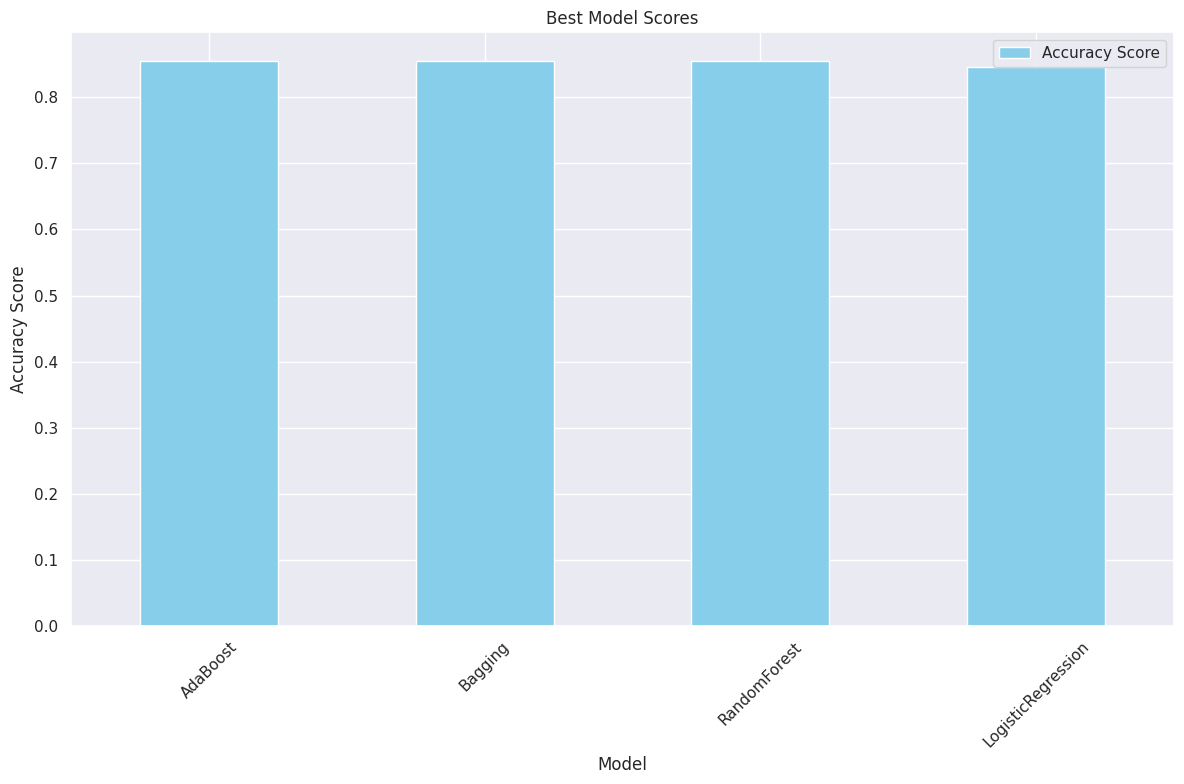

In [75]:
import pandas as pd
import matplotlib.pyplot as plt



# Creating the DataFrame
data = [grid_best_score_logreg, grid_best_score_rf, grid_best_score_ab, grid_best_score_bc]
index = ['LogisticRegression', 'RandomForest', 'AdaBoost', 'Bagging']
columns = ['Accuracy Score']
df = pd.DataFrame(data, index=index, columns=columns)

# Sorting the DataFrame by 'Accuracy Score'
df_sorted = df.sort_values(by='Accuracy Score', ascending=False)

# Creating the histogram
df_sorted.plot(kind='bar', color='skyblue')
plt.title('Best Model Scores')
plt.xlabel('Model')
plt.ylabel('Accuracy Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [73]:
print("Number of estimators:",grid_best_params_ab.get_params()['n_estimators'])

Number of estimators: 70
